In [1]:
import numpy as np
from numpy import all, any, array, arctan2, cos, sin, exp, dot, log, logical_and, roll, sqrt, stack, trace, unravel_index, pi, deg2rad, rad2deg, where, zeros, floor, full, nan, isnan, round, float32
from numpy.linalg import det, lstsq, norm
from functools import cmp_to_key
import cv2
from cv2 import resize, GaussianBlur, subtract, KeyPoint, INTER_LINEAR, INTER_NEAREST
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import argparse
import math
from google.colab.patches import cv2_imshow
import cv2

## Global Variables ##

In [2]:
# Determines the length of floats the SIFT function will tolerate
float_tolerance = 1e-7

# Determines whether to run SIFT in verbose mode
# (Prints out messages for debugging)
VERBOSE_MODE = False

# SIFT Implementation #

Please note: This implementation is largely based on the one originally created by Russ Islam, which can be found here:
https://github.com/rmislam/PythonSIFT

## Image Pyramid Functions ##

In [3]:
# Generate the base image from the given input image
# by upsampling by 2 in both directions and then applying
# a Gaussian blur.
def generateBaseImage(image, sigma, assumed_blur):
    image = resize(image, (0, 0), fx=2, fy=2, interpolation=INTER_LINEAR)
    sigma_diff = sqrt(max((sigma ** 2) - ((2 * assumed_blur) ** 2), 0.01))
    
    # The image blur is now sigma instead of assumed_blur
    return GaussianBlur(image, (0, 0), sigmaX=sigma_diff, sigmaY=sigma_diff)  

# Compute number of octaves in the image pyramid based
# on the original OpenCV implementation.
# (Function of base image shape)
def computeOctaves(img_shape):
    return int(round(log(min(img_shape)) / log(2)-1))

# Generate a list of Gaussian Kernels at which to blur the image
# Default values of sigma, intervals, and octaves are based on section 3
# of David G. Lowe's paper.
def generateGaussianKernels(sigma, intervals):
    # Set number of intervals
    images_per_octave = intervals + 3
    k = 2 ** (1.0 / intervals) # Normalise
    
    # Scale of gaussian blur necessary to go from one blur scale to the next within an octave
    gaussian_kernels = zeros(images_per_octave)
    gaussian_kernels[0] = sigma

    # For each image, work out the appropriate sigma value
    for image_index in range(1, images_per_octave):
        sigma_previous = (k ** (image_index - 1)) * sigma
        sigma_total = k * sigma_previous
        gaussian_kernels[image_index] = sqrt(sigma_total ** 2 - sigma_previous ** 2)
    return gaussian_kernels

# Generate the scale-space pyramid of Gaussian Images
# See: Lecture 7 - Page 14
def generateGaussianImages(img, octaves, kernels):
    
    gaussian_images = []
    
    for octave_index in range(octaves):
        gaussian_images_in_octave = []
        # First image in pyramid already has the correct blur
        gaussian_images_in_octave.append(img)
        
        # Blur each image
        for kernel in kernels[1:]:
            #print(kernel) DEBUG
            #img = gaussian_blur(img, 1, kernel) # ORIGINALLY 0
            img = GaussianBlur(img, (0, 0), sigmaX=kernel, sigmaY=kernel)
            gaussian_images_in_octave.append(img)
        
        # Append images to master array
        gaussian_images.append(gaussian_images_in_octave)
        octave_base = gaussian_images_in_octave[-3]
        
        # Resize image
        img = resize(octave_base, (int(octave_base.shape[1] / 2), int(octave_base.shape[0] / 2)), interpolation=INTER_NEAREST)
    
    return array(gaussian_images, dtype=object)

# Generate a Difference of Gaussian (DoG) image pyramid
def generateDoGImages(gaussian_images):
    
    dog_images = []
    
    # Similar process to latter function
    for gaussian_images_in_octave in gaussian_images:
        dog_images_in_octave = []
        
        for first_image, second_image in zip(gaussian_images_in_octave, gaussian_images_in_octave[1:]):
            # Ordinary subtraction will not work because the images are unsigned integers
            dog_images_in_octave.append(subtract(second_image, first_image))
        
        dog_images.append(dog_images_in_octave)
        
    return array(dog_images, dtype=object)

## Scale Space Extrema Functions ##

In [4]:
# Find the pixel positions of all Scale-Space Extrema in the image pyramid
def findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width, contrast_threshold=0.04):

    # From OpenCV implementation
    threshold = floor(0.5 * contrast_threshold / num_intervals * 255)  
    keypoints = []

    for octave_index, dog_images_in_octave in enumerate(dog_images):
        for image_index, (first_image, second_image, third_image) in enumerate(zip(dog_images_in_octave, dog_images_in_octave[1:], dog_images_in_octave[2:])):
            # (i, j) is the center of the 3x3 array
            for i in range(image_border_width, first_image.shape[0] - image_border_width):
                for j in range(image_border_width, first_image.shape[1] - image_border_width):
                    # Checks for extrenum values
                    if isPixelAnExtremum(first_image[i-1:i+2, j-1:j+2], second_image[i-1:i+2, j-1:j+2], third_image[i-1:i+2, j-1:j+2], threshold):
                        localization_result = localizeExtremumViaQuadraticFit(i, j, image_index + 1, octave_index, num_intervals, dog_images_in_octave, sigma, contrast_threshold, image_border_width)
                        if localization_result is not None:
                            keypoint, localized_image_index = localization_result
                            keypoints_with_orientations = computeKeypointsWithOrientations(keypoint, octave_index, gaussian_images[octave_index][localized_image_index])
                            for keypoint_with_orientation in keypoints_with_orientations:
                                keypoints.append(keypoint_with_orientation)
    return keypoints

# Returns true if the centre element of the 3x3x3 input array is strictly greater
# than or less than all of its neighbours, and false otherwise
def isPixelAnExtremum(first_subimage, second_subimage, third_subimage, threshold):
  centre_pixel_value = second_subimage[1,1]

  # Checks if pixel value is above the given threshold
  if abs(centre_pixel_value) > threshold:
    if centre_pixel_value > 0:
      # Check pixel against its neighbours
      return all(centre_pixel_value >= first_subimage) and \
                   all(centre_pixel_value >= third_subimage) and \
                   all(centre_pixel_value >= second_subimage[0, :]) and \
                   all(centre_pixel_value >= second_subimage[2, :]) and \
                   centre_pixel_value >= second_subimage[1,0] and \
                   centre_pixel_value >= second_subimage[1,2]
    elif centre_pixel_value < 0:
        return all(centre_pixel_value <= first_subimage) and \
                all(centre_pixel_value <= third_subimage) and \
                all(centre_pixel_value <= second_subimage[0, :]) and \
                all(centre_pixel_value <= second_subimage[2, :]) and \
                centre_pixel_value <= second_subimage[1,0] and \
                centre_pixel_value <= second_subimage[1,2]
  return False

# Iteratively refine pixel positions of Scale Space extrema
# via quadratic fit around each extremum's neighbors
def localizeExtremumViaQuadraticFit(i, j, image_index, octave_index, intervals, dog_images_in_octave, 
                                    sigma, contrast_threshold, image_border_width, 
                                    eigenvalue_ratio=10, attempts_until_convergence=5):
  extremum_is_outside_image = False
  image_shape = dog_images_in_octave[0].shape

  for attempt_index in range(attempts_until_convergence):
    # We need to convert from uint8 to float32 to compute derivatives
    # after which we need to rescale pixel values to [0, 1] to apply Lowe's thresholds
    first_image, second_image, third_image = dog_images_in_octave[image_index-1:image_index+2]
    pixel_cube = stack([first_image[i-1:i+2, j-1:j+2],
                        second_image[i-1:i+2, j-1:j+2],
                        third_image[i-1:i+2, j-1:j+2]]).astype('float32') / 255.
    # Compute the gradient and hessian values
    gradient = computeGradientAtCentrePixel(pixel_cube)
    hessian = computeHessianAtCentrePixel(pixel_cube)

    # Compute the least-squares solution of the hessian and the gradient matrices
    extremum_update = -lstsq(hessian, gradient, rcond=None)[0]
    if abs(extremum_update[0]) < 0.5 and abs(extremum_update[1]) < 0.5 and abs(extremum_update[2]) < 0.5:
        break
    j += int(round(extremum_update[0]))
    i += int(round(extremum_update[1]))
    image_index += int(round(extremum_update[2]))

    # Make sure the new pixel_cube will lie entirely within the image
    if i < image_border_width or i >= image_shape[0] - image_border_width or j < image_border_width or j >= image_shape[1] - image_border_width or image_index < 1 or image_index > intervals:
        extremum_is_outside_image = True
        break

  # Logging functions
  if extremum_is_outside_image:
      #logger.debug('Updated extremum moved outside of image before reaching convergence. Skipping...')
      return None
  if attempt_index >= attempts_until_convergence - 1:
      #logger.debug('Exceeded maximum number of attempts without reaching convergence for this extremum. Skipping...')
      return None

  functionValueAtUpdatedExtremum = pixel_cube[1, 1, 1] + 0.5 * dot(gradient, extremum_update)
  if abs(functionValueAtUpdatedExtremum) * intervals >= contrast_threshold:
      xy_hessian = hessian[:2, :2]
      xy_hessian_trace = trace(xy_hessian)
      xy_hessian_det = det(xy_hessian)
      if xy_hessian_det > 0 and eigenvalue_ratio * (xy_hessian_trace ** 2) < ((eigenvalue_ratio + 1) ** 2) * xy_hessian_det:
          # Contrast check passed -- construct and return OpenCV KeyPoint object
          # MAKE OWN KEYPOINT^^^
          keypoint = KeyPoint()
          keypoint.pt = ((j + extremum_update[0]) * (2 ** octave_index), (i + extremum_update[1]) * (2 ** octave_index))
          keypoint.octave = octave_index + image_index * (2 ** 8) + int(round((extremum_update[2] + 0.5) * 255)) * (2 ** 16)
          # Octave_index + 1 because the input image was doubled
          keypoint.size = sigma * (2 ** ((image_index + extremum_update[2]) / float32(intervals))) * (2 ** (octave_index + 1)) 
          keypoint.response = abs(functionValueAtUpdatedExtremum)
          return keypoint, image_index
  return None

# Approximate the gradient at the centre pixel (of 3x3x3 array)
# by using the "Central Difference" formula (Order: O(h^2))
# See: https://learn.lboro.ac.uk/archive/olmp/olmp_resources/pages/workbooks_1_50_jan2008/Workbook31/31_3_num_diff.pdf
def computeGradientAtCentrePixel(pixel_array):
  # Central Difference formula considering h (step size) of order O(h^2) for f'(x) 
  # is (f(x + h) - f(x - h)) / (2 * h)
  # Since h=1 in this case, we get: f'(x) = (f(x + 1) - f(x - 1)) / 2
  # NOTE: x corresponds to second array axis, y corresponds to first array axis, and s (scale) corresponds to third array axis
  dx = 0.5 * (pixel_array[1, 1, 2] - pixel_array[1, 1, 0])
  dy = 0.5 * (pixel_array[1, 2, 1] - pixel_array[1, 0, 1])
  ds = 0.5 * (pixel_array[2, 1, 1] - pixel_array[0, 1, 1])

  return array([dx, dy, ds])

# Same principles as the function above
def computeHessianAtCentrePixel(pixel_array):
  
  # Central Difference formula considering h (step size) of order O(h^2) for 
  # (d^2) f(x, y) / (dx dy) = (f(x + h, y + h) - f(x + h, y - h) - f(x - h, y + h) + f(x - h, y - h)) / (4 * h ^ 2)
  # Since h=1 in this case, we get: 
  # (d^2) f(x, y) / (dx dy) = (f(x + 1, y + 1) - f(x + 1, y - 1) - f(x - 1, y + 1) + f(x - 1, y - 1)) / 4
  
  centre_pixel_value = pixel_array[1,1,1]

  dxx = pixel_array[1,1,2] - 2 * centre_pixel_value + pixel_array[1,1,0]
  dyy = pixel_array[1,2,1] - 2 * centre_pixel_value + pixel_array[1,0,1]
  dss = pixel_array[2,1,1] - 2 * centre_pixel_value + pixel_array[0,1,1]

  dxy = 0.25 * (pixel_array[1,2,2] - pixel_array[1,2,0] - pixel_array[1,0,2] + pixel_array[1,0,0])
  dxs = 0.25 * (pixel_array[2,1,2] - pixel_array[2,1,0] - pixel_array[0,1,2] + pixel_array[0,1,0])
  dys = 0.25 * (pixel_array[2,2,1] - pixel_array[2,0,1] - pixel_array[0,2,1] + pixel_array[0,0,1])
  return array([[dxx, dxy, dxs], 
              [dxy, dyy, dys],
              [dxs, dys, dss]])

## Keypoint Orientation Function ##

In [5]:
# Computes the orientations of each keypoint
def computeKeypointsWithOrientations(keypoint, octave_index, gaussian_image, radius_factor=3, 
                                     num_bins=36, peak_ratio=0.8, scale_factor=1.5):
  keypoints_with_orientations = []
  image_shape = gaussian_image.shape

  # Comparison with keypoint.size computation in "localizeExtremumViaQuadraticFit()"
  scale = scale_factor * keypoint.size / float32(2 ** (octave_index + 1))

  # Prepare histogram values
  radius = int(round(radius_factor * scale))
  weight_factor = -0.5 / (scale ** 2)
  raw_histogram = zeros(num_bins)
  smooth_histogram = zeros(num_bins)

  # Go through the Y-range
  for i in range(-radius, radius + 1):
        region_y = int(round(keypoint.pt[1] / float32(2 ** octave_index))) + i
        if region_y > 0 and region_y < image_shape[0] - 1:
            # Go through the X-range
            for j in range(-radius, radius + 1):
                region_x = int(round(keypoint.pt[0] / float32(2 ** octave_index))) + j
                if region_x > 0 and region_x < image_shape[1] - 1:
                    dx = gaussian_image[region_y, region_x + 1] - gaussian_image[region_y, region_x - 1]
                    dy = gaussian_image[region_y - 1, region_x] - gaussian_image[region_y + 1, region_x]
                    
                    gradient_magnitude = sqrt(dx * dx + dy * dy)
                    gradient_orientation = rad2deg(arctan2(dy, dx))
                    
                    # Constant in front of exponential can be dropped since peaks will be found later
                    weight = exp(weight_factor * (i ** 2 + j ** 2))  
                    histogram_index = int(round(gradient_orientation * num_bins / 360.))
                    raw_histogram[histogram_index % num_bins] += weight * gradient_magnitude
  
  # Iterate through number of histogram bins
  for n in range(num_bins):
        smooth_histogram[n] = (6 * raw_histogram[n] + 4 * (raw_histogram[n - 1] + raw_histogram[(n + 1) % num_bins]) + raw_histogram[n - 2] + raw_histogram[(n + 2) % num_bins]) / 16.
  
  orientation_max = max(smooth_histogram)
  orientation_peaks = where(logical_and(smooth_histogram > roll(smooth_histogram, 1), smooth_histogram > roll(smooth_histogram, -1)))[0]
  
  # For each peak value in orientation_peaks
  for peak_index in orientation_peaks:
      peak_value = smooth_histogram[peak_index]
      if peak_value >= peak_ratio * orientation_max:
          # Quadratic peak interpolation
          # The interpolation update is given by equation (6.30) in:
          # https://ccrma.stanford.edu/~jos/sasp/Quadratic_Interpolation_Spectral_Peaks.html

          left_value = smooth_histogram[(peak_index - 1) % num_bins]
          right_value = smooth_histogram[(peak_index + 1) % num_bins]
          interpolated_peak_index = (peak_index + 0.5 * (left_value - right_value) / (left_value - 2 * peak_value + right_value)) % num_bins
          orientation = 360. - interpolated_peak_index * 360. / num_bins
          if abs(orientation - 360.) < float_tolerance:
              orientation = 0
          new_keypoint = KeyPoint(*keypoint.pt, keypoint.size, orientation, keypoint.response, keypoint.octave)
          keypoints_with_orientations.append(new_keypoint)
  return keypoints_with_orientations


## Duplicate Keypoint Removal Functions ##

In [6]:
# Returns true if the first keypoint is "less" than the second
# Used in the next function to remove duplicate keypoints
def compareKeypoints(keypoint1, keypoint2):

  # All attributes of the keypoints are compared
  if keypoint1.pt[0] != keypoint2.pt[0]:
    return keypoint1.pt[0] - keypoint2.pt[0]
  if keypoint1.pt[1] != keypoint2.pt[1]:
    return keypoint1.pt[1] - keypoint2.pt[1]
  if keypoint1.size != keypoint2.size:
    return keypoint2.size - keypoint1.size
  if keypoint1.angle != keypoint2.angle:
    return keypoint1.angle - keypoint2.angle
  if keypoint1.response != keypoint2.response:
    return keypoint2.response - keypoint1.response
  if keypoint1.octave != keypoint2.octave:
    return keypoint2.octave - keypoint1.octave
  return keypoint2.class_id - keypoint1.class_id

# Sorts the keypoints and then removes any duplicates
def removeDuplicateKeypoints(keypoints):
    # Checks if there is only 1 or no keypoints
    if len(keypoints) < 2:
        return keypoints
    
    # The sort method is called with a key pointing to the previous function.
    # This allows the program to run the function on each element while it is sorting.
    keypoints.sort(key=cmp_to_key(compareKeypoints))
    unique_keypoints = [keypoints[0]]
    
    # Remove the duplicate keypoints
    for next_keypoint in keypoints[1:]:
        last_unique_keypoint = unique_keypoints[-1]
        if last_unique_keypoint.pt[0] != next_keypoint.pt[0] or \
           last_unique_keypoint.pt[1] != next_keypoint.pt[1] or \
           last_unique_keypoint.size != next_keypoint.size or \
           last_unique_keypoint.angle != next_keypoint.angle:
            unique_keypoints.append(next_keypoint)
            
    return unique_keypoints

## Keypoint Scale Conversion Function ##

In [7]:
# Converts the keypoint point, size, and octave to the size to the input image
def convertKeypointsToInputImageSize(keypoints):

  converted_keypoints = []

  for keypoint in keypoints:
    keypoint.pt = tuple(0.5 * array(keypoint.pt))
    keypoint.size *= 0.5

    # The "~" is the bitwise operator. It returns (-x) - 1 (e.g. ~4 = -5)
    # The "|" operator is the union operator for sets, but here it is used
    # as a standard binary operator <- CHECK!!!
    keypoint.octave = (keypoint.octave & ~255) | ((keypoint.octave - 1) & 255)

    # Add the newly converted keypoint to array
    converted_keypoints.append(keypoint)
  
  return converted_keypoints

## Descriptor Generation ##

In [8]:
# Compute octave, layer, and scale from a keypoint
def unpackOctave(keypoint):
    octave = keypoint.octave & 255
    layer = (keypoint.octave >> 8) & 255
    if octave >= 128:
        octave = octave | -128
    scale = 1 / float32(1 << octave) if octave >= 0 else float32(1 << -octave)
    return octave, layer, scale

# Generates the descriptors for each keypoint
def generateDescriptors(keypoints, gaussian_images, window_width=4, num_bins=8,
                        scale_multiplier=3, descriptor_max_value=0.2):
    
    descriptors = []

    # Iterate through each keypoint
    for keypoint in keypoints:
        
        # Here, we will create a new gradient histogram for each
        # keypoint. Then, we also calculate the gradient magnitude
        # and orientation of each pixel.
        
        # Unpack the octave and begin histogram creation
        octave, layer, scale = unpackOctave(keypoint)
        gaussian_image = gaussian_images[octave + 1, layer]
        num_rows, num_cols = gaussian_image.shape
        point = round(scale * array(keypoint.pt)).astype('int')
        bins_per_degree = num_bins / 360.
        
        # Work out the orientation
        angle = 360. - keypoint.angle
        cos_angle = cos(deg2rad(angle))
        sin_angle = sin(deg2rad(angle))
        weight_multiplier = -0.5 / ((0.5 * window_width) ** 2)
        
        # We don't actually "draw" the histograms, we simply keep track of the
        # bin values and bin indexes.
        row_bin_list = []
        col_bin_list = []
        magnitude_list = []
        orientation_bin_list = []
        
        # The first two dimensions are increased by 2 to account for border effects
        histogram_tensor = zeros((window_width + 2, window_width + 2, num_bins))   

        # Descriptor window size (described by half_width) follows OpenCV convention
        hist_width = scale_multiplier * 0.5 * scale * keypoint.size
        
        # sqrt(2) corresponds to diagonal length of a pixel
        half_width = int(round(hist_width * sqrt(2) * (window_width + 1) * 0.5))
        
        # Ensure half_width lies within image
        half_width = int(min(half_width, sqrt(num_rows ** 2 + num_cols ** 2)))     

        # Calculating each pixel's (hence iteration) gradient magnitude and orientation
        for row in range(-half_width, half_width + 1):
            for col in range(-half_width, half_width + 1):
                row_rot = col * sin_angle + row * cos_angle
                col_rot = col * cos_angle - row * sin_angle
                row_bin = (row_rot / hist_width) + 0.5 * window_width - 0.5
                col_bin = (col_rot / hist_width) + 0.5 * window_width - 0.5
                if row_bin > -1 and row_bin < window_width and col_bin > -1 and col_bin < window_width:
                    window_row = int(round(point[1] + row))
                    window_col = int(round(point[0] + col))
                    if window_row > 0 and window_row < num_rows - 1 and window_col > 0 and window_col < num_cols - 1:
                        dx = gaussian_image[window_row, window_col + 1] - gaussian_image[window_row, window_col - 1]
                        dy = gaussian_image[window_row - 1, window_col] - gaussian_image[window_row + 1, window_col]
                        gradient_magnitude = sqrt(dx * dx + dy * dy)
                        gradient_orientation = rad2deg(arctan2(dy, dx)) % 360
                        weight = exp(weight_multiplier * ((row_rot / hist_width) ** 2 + (col_rot / hist_width) ** 2))
                        row_bin_list.append(row_bin)
                        col_bin_list.append(col_bin)
                        magnitude_list.append(weight * gradient_magnitude)
                        orientation_bin_list.append((gradient_orientation - angle) * bins_per_degree)

        for row_bin, col_bin, magnitude, orientation_bin in zip(row_bin_list, col_bin_list, magnitude_list, orientation_bin_list):
            
            # Smoothing via trilinear interpolation
            # Notations follows https://en.wikipedia.org/wiki/Trilinear_interpolation
            # Note that we are really doing the inverse of trilinear interpolation here (we take the center value of the cube and distribute it among its eight neighbors)
            row_bin_floor, col_bin_floor, orientation_bin_floor = floor([row_bin, col_bin, orientation_bin]).astype(int)
            row_fraction, col_fraction, orientation_fraction = row_bin - row_bin_floor, col_bin - col_bin_floor, orientation_bin - orientation_bin_floor
            if orientation_bin_floor < 0:
                orientation_bin_floor += num_bins
            if orientation_bin_floor >= num_bins:
                orientation_bin_floor -= num_bins

            c1 = magnitude * row_fraction
            c0 = magnitude * (1 - row_fraction)
            c11 = c1 * col_fraction
            c10 = c1 * (1 - col_fraction)
            c01 = c0 * col_fraction
            c00 = c0 * (1 - col_fraction)
            c111 = c11 * orientation_fraction
            c110 = c11 * (1 - orientation_fraction)
            c101 = c10 * orientation_fraction
            c100 = c10 * (1 - orientation_fraction)
            c011 = c01 * orientation_fraction
            c010 = c01 * (1 - orientation_fraction)
            c001 = c00 * orientation_fraction
            c000 = c00 * (1 - orientation_fraction)

            histogram_tensor[row_bin_floor + 1, col_bin_floor + 1, orientation_bin_floor] += c000
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 1, (orientation_bin_floor + 1) % num_bins] += c001
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 2, orientation_bin_floor] += c010
            histogram_tensor[row_bin_floor + 1, col_bin_floor + 2, (orientation_bin_floor + 1) % num_bins] += c011
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 1, orientation_bin_floor] += c100
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 1, (orientation_bin_floor + 1) % num_bins] += c101
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 2, orientation_bin_floor] += c110
            histogram_tensor[row_bin_floor + 2, col_bin_floor + 2, (orientation_bin_floor + 1) % num_bins] += c111

        descriptor_vector = histogram_tensor[1:-1, 1:-1, :].flatten()  # Remove histogram borders
        # Threshold and normalize descriptor_vector
        threshold = norm(descriptor_vector) * descriptor_max_value
        descriptor_vector[descriptor_vector > threshold] = threshold
        descriptor_vector /= max(norm(descriptor_vector), float_tolerance)
        # Multiply by 512, round, and saturate between 0 and 255 to convert from float32 to unsigned char (OpenCV convention)
        descriptor_vector = round(512 * descriptor_vector)
        descriptor_vector[descriptor_vector < 0] = 0
        descriptor_vector[descriptor_vector > 255] = 255
        descriptors.append(descriptor_vector)
    return array(descriptors, dtype='float32')

## Main SIFT Function ##

In [9]:
# Computes the SIFT descriptors and keypoints for a given image
def computeKeypointsAndDescriptors(image, sigma=1.6, num_intervals=3, assumed_blur=0.5, image_border_width=5):
    
    if (VERBOSE_MODE == True):
        img_temp = image
        image = image.astype('float32')
        print("GENERATING BASE IMAGE...")
        base_image = generateBaseImage(image, sigma, assumed_blur)
        print("OK!")
        print("COMPUTING OCTAVES...")
        num_octaves = computeOctaves(base_image.shape)
        print("OK!")
        print("GENERATING KERNELS...")
        gaussian_kernels = generateGaussianKernels(sigma, num_intervals)
        print("OK!")
        print("GENERATING GAUSSIAN IMAGES...")
        gaussian_images = generateGaussianImages(base_image, num_octaves, gaussian_kernels)
        print("OK!")
        print("GENERATING DIFFERENCE OF GAUSSIAN IMAGES...")
        dog_images = generateDoGImages(gaussian_images)
        print("OK!")
        print("ATTEMPTING TO FIND SCALE-SPACE EXTREMA... (PLEASE WAIT)")
        keypoints = findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width)
        print("OK!")
        print("REMOVING DUPLICATE KEYPOINTS...")
        keypoints = removeDuplicateKeypoints(keypoints)
        print("OK!")
        print("CONVERTING KEYPOINTS TO INPUT IMAGE SIZE...")
        keypoints = convertKeypointsToInputImageSize(keypoints)
        print("OK!")
        print(keypoints)
        print("GENERATING DESCRIPTORS...")
        descriptors = generateDescriptors(keypoints, gaussian_images)
        print("OK!")
        print("DONE! RETURNING KEYPOINTS AND DESCRIPTORS... (PLEASE WAIT)")
        
        return keypoints, descriptors
    else:
        img_temp = image
        image = image.astype('float32')
        base_image = generateBaseImage(image, sigma, assumed_blur)
        num_octaves = computeOctaves(base_image.shape)
        gaussian_kernels = generateGaussianKernels(sigma, num_intervals)
        gaussian_images = generateGaussianImages(base_image, num_octaves, gaussian_kernels)
        dog_images = generateDoGImages(gaussian_images)
        keypoints = findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, image_border_width)
        keypoints = removeDuplicateKeypoints(keypoints)
        keypoints = convertKeypointsToInputImageSize(keypoints)
        descriptors = generateDescriptors(keypoints, gaussian_images)
        
        return keypoints, descriptors
    

In [20]:
img1 = cv2.imread('cow.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

# STEP 1
# Gets keypoints and descriptors of a given image
kp, desc = computeKeypointsAndDescriptors(img1)

In [21]:
#for d in kp:
  #print(d.pos)

#yeet = cv2.drawKeypoints(img1, kp, img1, color=(255,0,0))

#cv2.imshow('yee', yeet)

#waits for user to press any key 
#(this is necessary to avoid Python kernel form crashing)
#cv2.waitKey(0) 

#closing all open windows 
#cv2.destroyAllWindows()

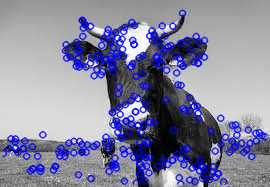

280


In [22]:
yeet = cv2.drawKeypoints(img1, kp, img1, color=(255,0,0))

cv2_imshow(yeet)

print(len(desc))

#waits for user to press any key 
#(this is necessary to avoid Python kernel form crashing)
#cv2.waitKey(0) 

#closing all open windows 
#cv2.destroyAllWindows()

# K-Means Clustering Implementation (Step 2) #

In [34]:
def kmeans_cluster(k, descriptors, tolerance=0.001, max_iterations=300):
    centroids = {}
    
    for x in range(k):
        centroids[x] = descriptors[x]
        
    for x in range(max_iterations):
        
        classifications = {}
        distances = {}
        for y in range(k):
            classifications[y] = []
            
        for d in descriptors:
            distances = [np.linalg.norm(d - centroids[c]) for c in centroids]
            classification = distances.index(min(distances))
                         
            classifications[classification].append(d)
        
        prev_centroids = dict(centroids)
        
        for classification in classifications:
            centroids[classification] = np.average(classifications[classification], axis=0)
        
        optimised = True
        
        for c in centroids:
            original_centroid = prev_centroids[c]
            current_centroid = centroids[c]
            
            if np.sum((current_centroid - original_centroid) / original_centroid*100.0) > tolerance:
                print(np.sum((current_centroid - original_centroid) / original_centroid*100.0))
                
                optimised = False
        

        if optimised:
            break

 
    return centroids

def generate_dictionary(descriptors):

    # 500 means that we will have 500 clusters 
    dictionarySize = 75
    # extract descriptors using sift function from step 1

    # build the dictionary
    dictionary = kmeans_cluster(2, descriptors)


    return dictionary

keypoints, descriptors  = computeKeypointsAndDescriptors(img1)

#for d in descriptors:
  #print(d)

generate_dictionary(descriptors)

inf
inf
222.02727
41.09787
78.860695
76.128235
55.4609


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide


{0: array([ 35.684784 ,  35.494564 ,  26.461956 ,  24.141304 ,  16.913044 ,
          8.771739 ,   5.5326085,  10.570652 ,  88.902176 ,  49.885868 ,
         18.994566 ,  14.222826 ,   9.63587  ,   7.8152175,  10.668478 ,
         29.663044 ,  63.608696 ,  25.358696 ,  10.684783 ,  11.038043 ,
         13.26087  ,  15.592391 ,  21.445652 ,  32.380436 ,  19.065218 ,
         13.934783 ,  11.603261 ,   9.413043 ,  11.918478 ,  14.592391 ,
         18.554348 ,  16.065218 ,  45.41848  ,  28.233696 ,  21.782608 ,
         24.358696 ,  24.967392 ,  17.483696 ,  12.027174 ,  15.619565 ,
        131.88043  ,  51.91848  ,  15.26087  ,   9.076087 ,   6.679348 ,
          6.1847825,  10.815217 ,  45.369564 ,  88.478264 ,  28.320652 ,
         11.119565 ,  16.918478 ,  21.902174 ,  22.038044 ,  23.891304 ,
         34.119564 ,  24.02174  ,  14.956522 ,  14.978261 ,  13.586957 ,
         14.98913  ,  18.63587  ,  21.98913  ,  18.048914 ,  41.179348 ,
         13.005435 ,   6.9402175,  14.021739 ,  

# STEP 3 # 
 Euclidean distance
 

In [51]:
#get centroids from part 2
centroids = {}
centroids = kmeans_cluster(5,descriptors)

for c in centroids:
  print("Centroids: ", c )


# Euclidean distance of image descriptors with centroids
#subtract descriptos with centroids
  for d in descriptors:
    for c in centroids:
          distances.append(np.linalg.norm(d - c))

#printing the euclidean distances
  for d in distances:
    print(d)  
  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide


Streaming output truncated to the last 5000 lines.
511.1135
504.20135
497.4505
490.86758
484.4595
512.24896
506.8422
501.63232
496.6256
491.82822
512.48315
507.87103
503.47095
499.28848
495.3292
512.50757
506.74252
501.16663
495.78625
490.6078
512.2265
506.42276
500.80734
495.38672
490.16733
512.3407
505.1287
498.06927
491.169
484.43472
512.0029
506.64484
501.4848
496.52896
491.78348
511.35507
505.5413
499.916
494.4856
489.2566
511.26608
505.196
499.30853
493.61017
488.10757
511.32083
505.2435
499.34857
493.64258
488.13214
511.9414
506.38324
501.01895
495.85483
490.89713
512.4051
506.17487
500.123
494.256
488.5806
512.7514
507.40714
502.2609
497.31882
492.58704
511.85153
506.03162
500.39984
494.96262
489.72644
512.52026
506.27167
500.20096
494.31467
488.61948
511.917
507.5953
503.4908
499.60886
495.95462
512.35046
505.30487
498.4165
491.692
485.13812
511.6884
504.4829
497.4304
490.53748
483.8109
511.7724
506.59354
501.6164
496.84705
492.2916
512.50366
506.98718
501.66522
496.54407
491.

#Part 3.4 #
##Representation of each image as a histogram ##


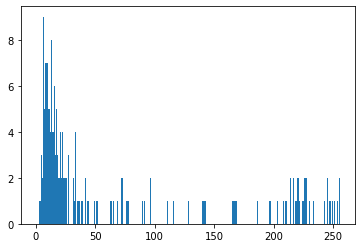

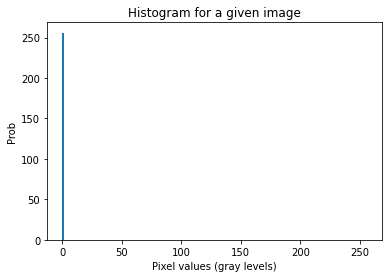

In [71]:
# Histogram of an image with gray levels
# we have the img1 from before so we can use that

#need to slice it into 2D
import matplotlib.image as mpimg

img1 = mpimg.imread('deer.jfif')

hist_b, bin_edges = np.histogram(img1[:,:,2], bins=256, range=[0, 256])

plt.hist(hist_b, bins=256, range =[0, 256])
plt.show()
plt.title("Histogram for a given image")
plt.xlabel("Pixel values (gray levels)")
plt.ylabel("Prob")



#Normalize the histogram
hist_norm = hist_b/sum(hist_b)
plt.hist(hist_norm, bins=256, range =[0, 256])
plt.show()